In [86]:
from functions import Schedule
import pandas as pd
import numpy as np
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from geopy.distance import geodesic

### Create a csv with all caldendars

In [2]:
# Create a dataframe with all schedules from 1979-80 to 2022-23
years = np.arange(1979, 2024)
dfs = []
for year in years :

    print(f'Fetching schedule for season {year-1}-{year} ...', end = '\r')
    dfs.append(Schedule(year))
    time.sleep(5)

data = pd.concat(dfs).reset_index(drop = True)
data.to_csv('data/Schedules_1979-2023.csv', index = None)

## Calendar features

In [112]:
# Load the schedule data
data = pd.read_csv('data/Schedules_1979-2023.csv')
data.head()

,Date,Year,HomeTm,AwayTm,Home,Away
0,1978-10-13,1979,DEN,SAS,Denver Nuggets,San Antonio Spurs
1,1978-10-13,1979,DET,NJN,Detroit Pistons,New Jersey Nets
2,1978-10-13,1979,IND,ATL,Indiana Pacers,Atlanta Hawks
3,1978-10-13,1979,NYK,HOU,New York Knicks,Houston Rockets
4,1978-10-13,1979,PHI,LAL,Philadelphia 76ers,Los Angeles Lakers


In [113]:
# Create mapping between teams and cities
cityMap = {'Denver Nuggets': 'Denver', 'Detroit Pistons': 'Detroit', 'Indiana Pacers': 'Indiana', 'New York Knicks': 'New York',
           'Philadelphia 76ers': 'Philadelphia', 'Phoenix Suns': 'Phoenix', 'Seattle SuperSonics': 'Seattle',
           'Washington Bullets': 'Washington', 'Boston Celtics': 'Boston', 'Golden State Warriors': 'San Francisco',
           'San Antonio Spurs':  'San Antonio', 'New Jersey Nets': 'Brooklyn', 'Atlanta Hawks': 'Atlanta',
           'San Diego Clippers':  'San Diego', 'New Orleans Jazz':  'New Orleans', 'Portland Trail Blazers': 'Portland',
           'Cleveland Cavaliers': 'Cleveland', 'Houston Rockets': 'Houston', 'Kansas City Kings':  'Kansas City',
           'Chicago Bulls': 'Chicago', 'Milwaukee Bucks': 'Milwaukee', 'Los Angeles Lakers':  'Los Angeles',
           'Utah Jazz': 'Salt Lake City', 'Dallas Mavericks': 'Dallas', 'Los Angeles Clippers': 'Los Angeles',
           'Sacramento Kings': 'Sacramento', 'Charlotte Hornets': 'Charlotte', 'Miami Heat': 'Miami', 'Orlando Magic': 'Orlando',
           'Minnesota Timberwolves': 'Minneapolis', 'Toronto Raptors': 'Toronto', 'Vancouver Grizzlies': 'Vancouver',
           'Washington Wizards': 'Washington', 'Memphis Grizzlies': 'Memphis', 'New Orleans Hornets':  'New Orleans',
           'Charlotte Bobcats': 'Charlotte', 'New Orleans/Oklahoma City Hornets': 'Oklahoma City', 
           'Oklahoma City Thunder':  'Oklahoma City', 'Brooklyn Nets': 'Brooklyn', 'New Orleans Pelicans':  'New Orleans'
            }

In [114]:
# Load and clean the city coordinates data -- add Canadian teams, keep higher population cities
cits, lats, lngs = ['Toronto', 'Vancouver'], [43.6532, 49.2827], [-79.3832, -123.1207] # Canadian cities
cities = pd.read_csv('data/uscities.csv')[['city', 'lat', 'lng', 'population']]
cities = pd.concat([cities, pd.DataFrame(zip(cits, lats, lngs, [1e9, 1e9]), columns = ['city', 'lat', 'lng', 'population'])]).sort_values('population', ascending = False).reset_index(drop = True)
cities = cities.drop_duplicates(subset = 'city', keep = 'first')

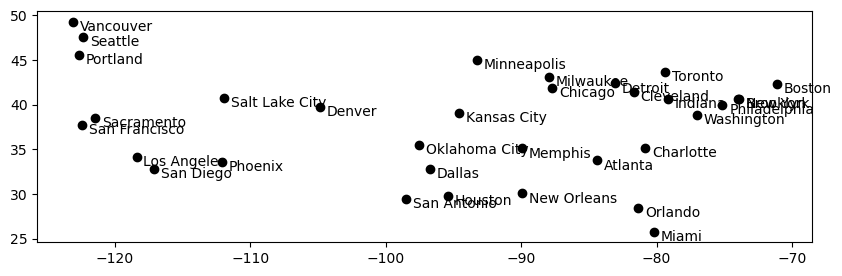

In [115]:
# Sanity check: cities distribution in the US
plt.figure(figsize = (10, 3))
for city in np.unique(list(cityMap.values())) :
    
    cityxy = cities.copy()[cities['city'] == city]
    x, y = cityxy['lng'].values[0], cityxy['lat'].values[0]
    plt.scatter(x, y, c = 'k')
    plt.annotate(city, xy = (x + 0.5, y - 1))

In [116]:
# Store the locations of the games
data['Location'] = data['Home'].apply(lambda x: cityMap.get(x))
# Merge the games with the geographic city data
data = data.merge(cities.rename(columns = {'city': 'Location'}), on = 'Location', how = 'left').drop(columns = ['population'])

In [117]:
def ComputeCalendarFeatures(tm, year) :

    # Select the games for the input year and team
    games = data.copy()[((data['HomeTm'] == tm) | (data['AwayTm'] == tm)) & (data['Year'] == year)]
    games['Date'] = pd.to_datetime(games['Date'])

    # Compute the average days of rest and # back to backs
    games['Day'] = games['Date'].apply(lambda x: x.date())
    avgRest = games['Date'].diff().mean().total_seconds() / 3600 / 24
    numBack2Back = (games['Day'].diff().apply(lambda x: x.total_seconds() / 3600 / 24) <= 1).sum()

    # Compute the total distance traveled upper and lower bounds
    coords = [(x, y) for x, y in zip(games['lat'], games['lng'])]
    tmCoords = (games[games['HomeTm'] == tm].lat.values[0], games[games['HomeTm'] == tm].lng.values[0])
    games['Distance'] = [np.nan] + [geodesic(pt1, pt2).kilometers for pt1, pt2 in zip(coords[:-1], coords[1:])]
    games['RoadtripDistance'] = [2 * geodesic(pt, tmCoords).kilometers for pt in coords]
    distLB = games['Distance'].sum()
    distUB = games['RoadtripDistance'].sum()

    return pd.DataFrame(zip([tm], [year], [avgRest], [numBack2Back], [distLB], [distUB]),
                        columns = ['Tm', 'Year', 'avgRest', 'Back2Backs', 'distTraveledLB', 'distTraveledUB'])

In [209]:
rows = []
for year in data['Year'].unique() :
    datayr = data.groupby('Year').get_group(year)
    for tm in datayr['HomeTm'].unique() :
        rows.append(ComputeCalendarFeatures(tm, year))

dataSchedule = pd.concat(rows).reset_index(drop = True)
dataSchedule.head()

,Tm,Year,avgRest,Back2Backs,distTraveledLB,distTraveledUB
0,DEN,1979,2.185185,21,85320.492449,146450.995650
1,DET,1979,2.185185,26,71242.030195,126065.369680
2,IND,1979,2.185185,23,62025.805460,139312.730959
3,NYK,1979,2.148148,21,72978.243834,158897.698552
4,PHI,1979,2.185185,21,69680.376943,151459.371894


In [210]:
# Normalize features by year
groupYear = dataSchedule.groupby('Year')
features = ['avgRest', 'Back2Backs', 'distTraveledLB', 'distTraveledUB']
for feature in features :
    dataSchedule[feature] = (dataSchedule[feature] - groupYear[feature].transform('mean')) / groupYear[feature].transform('std')

In [211]:
dataSchedule.to_csv('data/features_Schedule.csv', index = None)

In [ ]:
### TO-DO ###
# Opponent metrics: average strength of 82 opponents

In [134]:
### SMALL ASSESSMENT OF PREDICTIVE CAPABILITIES OF CALENDAR FEATURES
y = pd.read_csv('data/target_1979-2023.csv')
dataSchedule = dataSchedule.merge(y)

0.1706922797370922
-0.10726400855612345
0.09672551610404345
0.054878782154141256


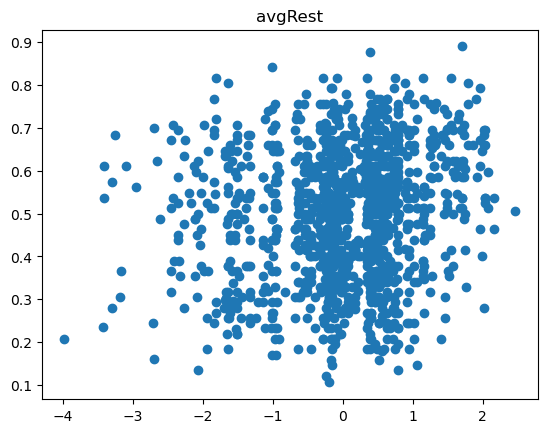

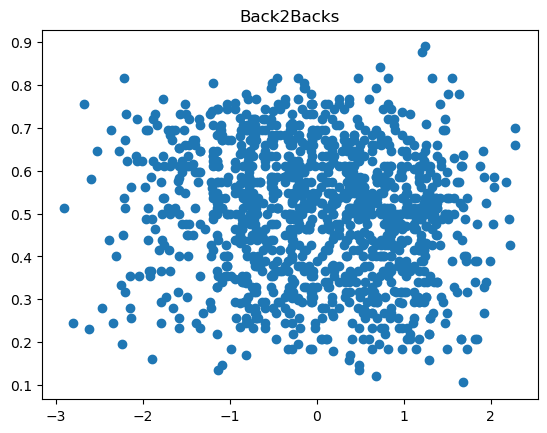

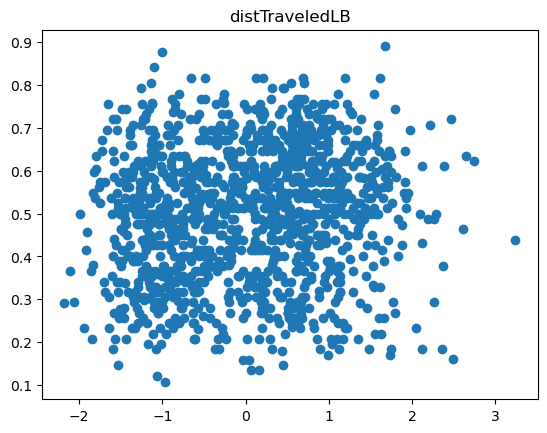

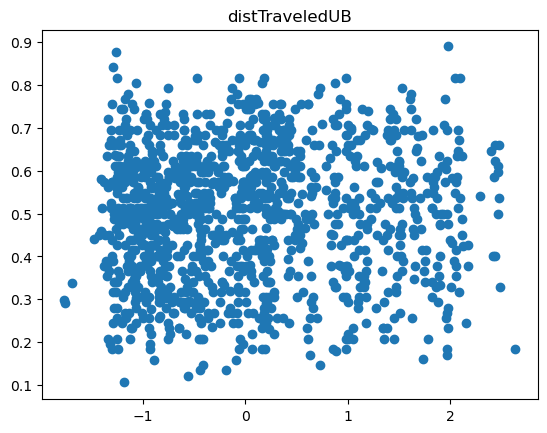

In [137]:
for f in features :

    plt.figure()
    plt.title(f)
    plt.scatter(dataSchedule[f], dataSchedule['W/L%'])
    print(np.corrcoef(dataSchedule[f], dataSchedule['W/L%'])[0,1])

In [93]:
### TO-DO ###
# Opponent metrics: average strength of 82 opponents

In [208]:
### SMALL ASSESSMENT OF PREDICTIVE CAPABILITIES OF CALENDAR FEATURES
features = ['avgRest', 'Back2Backs', 'distTraveledLB', 'distTraveledUB']
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataSchedule[features], dataSchedule['W/L%'], test_size = 0.2)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = 1 - sum((y_pred - y_test) ** 2) / sum((np.mean(y_train) - y_test) ** 2)

print(r2)
[f'{f}: {round(coef, 3)}' for f, coef in zip(features, model.coef_)]

0.06620417617731655


['avgRest: 0.023',
 'Back2Backs: -0.015',
 'distTraveledLB: 0.015',
 'distTraveledUB: -0.011']